In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.animation import FuncAnimation
plt.rcParams.update({
    'figure.figsize': (4.8, 2.7), 'font.size': 15,
    'lines.linewidth': 2,
    'xtick.labelsize': 'small', 'ytick.labelsize': 'small',
    'axes.spines.top': False, 'axes.spines.right': False,
    'savefig.dpi': 200,
})

import os, pickle
from pathlib import Path
import numpy as np
import torch
from jarvis.utils import tqdm

rng = np.random.default_rng()
FIG_PATH = Path('../figures')

In [2]:
from bisc import rcParams

# comment out the next two lines if 'stimulus' and 'response' already exist in the repository root folder
rcParams['stimulus_path'] = '/mnt/e/BISC_2023/stimulus'
rcParams['response_path'] = '/mnt/e/BISC_2023/response'

In [3]:
from bisc.data import get_session, get_trial_average, get_valid_idxs, align_responses

session_id = '62529070'
session = get_session(session_id)
trial_idxs, channel_idxs = get_valid_idxs(session)

# Get stimulus triggered average for multiple frequency bands

In [4]:
freqs = np.logspace(np.log10(4), np.log10(512), 36)
freqs = np.array([float('{:.2f}'.format(f)) for f in freqs])

taus_list, responses_mean_list, responses_std_list = [], [], []
for freq in tqdm(freqs, unit='freq'):
    taus, responses_mean, responses_std = get_trial_average(session, dt=0.5, transform={'type': 'morlet', 'freq': freq})
    taus_list.append(taus)
    responses_mean_list.append(responses_mean)
    responses_std_list.append(responses_std)
taus, responses_mean = align_responses(taus_list, responses_mean_list)
_, responses_std = align_responses(taus_list, responses_std_list)

  0%|                                                                                                         …

## Spectrogram of one channel (V1)

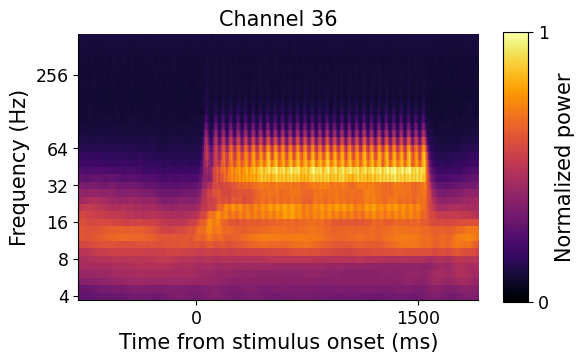

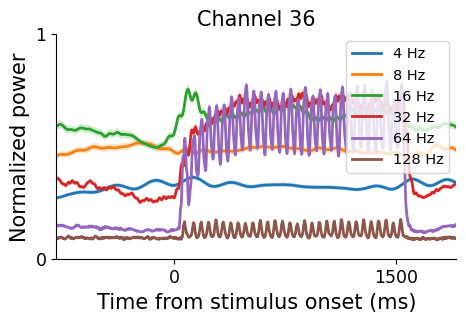

In [5]:
channel_idx = 36
r_max = responses_mean[:, channel_idx].max()

fig = plt.figure(figsize=(5, 3))
ax = fig.add_axes([0.05, 0.05, 0.8, 0.9])
dt = 0.5
h = ax.imshow(
    responses_mean[:, channel_idx]/r_max, extent=[taus.min()-dt/2, taus.max()+dt/2, np.log2(4)-0.1, np.log2(512)+0.1],
    origin='lower', vmin=0, aspect=250, cmap='inferno', interpolation='nearest',
)
cax = fig.add_axes([0.9, 0.05, 0.05, 0.9])
fig.colorbar(h, cax=cax, label='Normalized power', ticks=[0, 1])
ax.set_yticks([2, 3, 4, 5, 6, 8])
ax.set_yticklabels(['4', '8', '16', '32', '64', '256'])
ax.set_ylabel('Frequency (Hz)')
ax.set_xticks([0, 1500])
ax.set_xlabel('Time from stimulus onset (ms)')
ax.set_title(f'Channel {channel_idx}', fontsize='medium')
fig.savefig(FIG_PATH/'grating.spectrogram.svg')
# fig.savefig(FIG_PATH/'grating.spectrogram.png', bbox_inches='tight')

fig = plt.figure(figsize=(5, 2.5))
ax = fig.add_axes([0.1, 0.05, 0.8, 0.9])
lines, legends = [], []
for freq in [4, 8, 16, 32, 64, 128]:
    idx = list(freqs).index(freq)
    r_mean = responses_mean[idx, channel_idx]/r_max
    r_sem = responses_std[idx, channel_idx]/(len(trial_idxs)**0.5)/r_max
    h, = ax.plot(taus, r_mean)
    lines.append(h)
    legends.append(f'{freq} Hz')
    ax.fill_between(taus, r_mean-r_sem, r_mean+r_sem, alpha=0.2)
ax.legend(lines, legends, fontsize='x-small', loc='upper right')
ax.set_xlim([taus.min(), taus.max()])
ax.set_xticks([0, 1500])
ax.set_xlabel('Time from stimulus onset (ms)')
ax.set_yticks([0, 1])
ax.set_ylabel('Normalized power')
ax.set_title(f'Channel {channel_idx}', fontsize='medium')
fig.savefig(FIG_PATH/'grating.bands_c{:03d}.svg'.format(channel_idx))
# fig.savefig(FIG_PATH/'grating.bands_channel.png', bbox_inches='tight')

plt.show()

## Relative responses of all channels in different bands

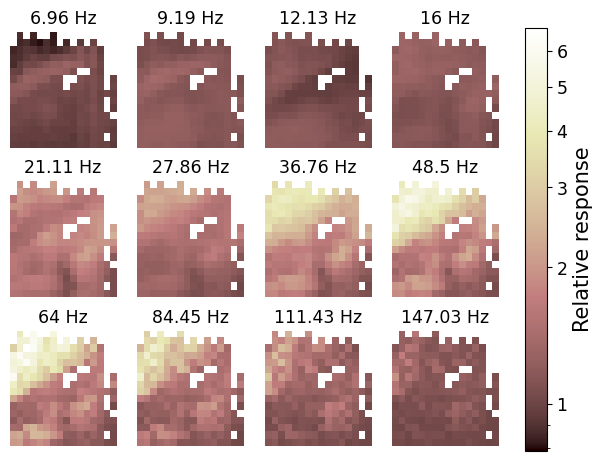

In [6]:
taus, responses_mean = align_responses(taus_list, responses_mean_list)
r_base = responses_mean[..., (taus>=-300)&(taus<=0)].mean(axis=-1)
r_grating = responses_mean[..., (taus>=750)&(taus<=1500)].mean(axis=-1)

c_mask = np.ones(r_base.shape[1]).astype(bool)
c_mask[channel_idxs] = False

r_ratio = r_grating/r_base
r_ratio[:, c_mask] = np.nan
r_ratio = r_ratio.reshape(-1, 16, 16)

# fig, axes = plt.subplots(2, 3, figsize=(6, 4))
# fig, axes = plt.subplots(3, 3, figsize=(5.5, 5.5))
fig, axes = plt.subplots(3, 4, figsize=(7, 5.5))
# freqs_toplot = [4, 8, 16, 32, 64, 128]
# freqs_toplot = [8, 13.93, 24.25, 42.22, 73.52, 128]
# freqs_toplot = [5.28, 8, 12.13, 18.38, 27.86, 42.22, 64, 97.01, 147.03]
freqs_toplot = [6.96, 9.19, 12.13, 16., 21.11, 27.86, 36.76, 48.5, 64, 84.45, 111.43, 147.03]
for freq, ax in zip(freqs_toplot, axes.ravel()):
    idx = list(freqs).index(freq)
    h = ax.imshow(r_ratio[idx], cmap='pink', extent=[0, 6.8, 0, 7.4], norm=colors.LogNorm(vmin=np.nanmin(r_ratio), vmax=np.nanmax(r_ratio)))
    ax.set_title('{:g} Hz'.format(freq), fontsize='small')
    ax.axis('off')
cbar = plt.colorbar(h, ax=axes, fraction=0.05, shrink=1, label='Relative response')
cbar.ax.set_yticks([1, 2, 3, 4, 5, 6])
cbar.ax.set_yticklabels(['1', '2', '3', '4', '5', '6'])
# fig.savefig(FIG_PATH/'grating.bands_chip.svg')

plt.show()

# Orientation tuning

## Single neuron

In [7]:
from bisc.data import get_baseline
from bisc.grating import grating_triggered_average

dt, freq = 0.5, 64
transform = {'type': 'morlet', 'freq': freq}

thetas, taus, responses_mean, responses_std, _ = grating_triggered_average(session, dt=dt, transform=transform)
r_base, r_unit = get_baseline(session, dt=dt, transform=transform)

Channel 36


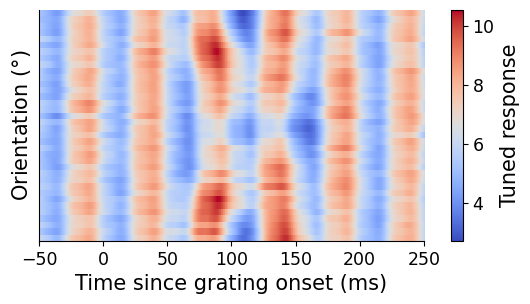

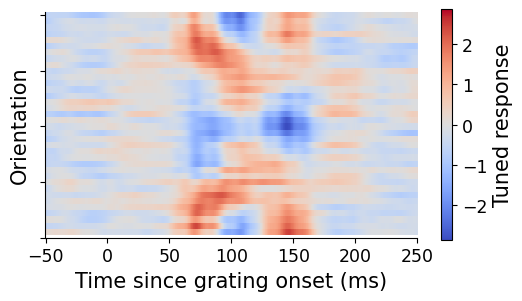

In [8]:
channel_idx = 36
print(f'Channel {channel_idx}')
vals = (responses_mean[:, channel_idx]-r_base[channel_idx])/r_unit[channel_idx]

vlim = np.abs(vals).max()
vmin, vmax = None, None
fig, ax = plt.subplots(figsize=(7, 3))
dt = 0.5
dtheta = thetas[1]-thetas[0]
h = ax.imshow(
    vals, vmin=vmin, vmax=vmax, cmap='coolwarm', interpolation='nearest', aspect=1,
    extent=[taus.min()-dt/2, taus.max()+dt/2, max(thetas)+dtheta/2, min(thetas)-dtheta/2],
)
fig.colorbar(h, label='Tuned response')
ax.set_yticks([])
ax.set_xlabel('Time since grating onset (ms)')
ax.set_ylabel(r'Orientation ($\degree$)')
# fig.savefig(FIG_PATH/'orientation.triggered.average_{:g}Hz_c{:03d}.svg'.format(transform['freq'], channel_idx))

r_t = vals[:, :600].reshape(-1, 6, 100).mean(axis=(0, 1))
r_t = np.tile(r_t, 7)[:601]
vals -= r_t
vlim = np.abs(vals).max()
vmin, vmax = -vlim, vlim

fig, ax = plt.subplots(figsize=(6, 3))
dt = 0.5
dtheta = thetas[1]-thetas[0]
h = ax.imshow(
    vals, vmin=vmin, vmax=vmax, cmap='coolwarm', interpolation='nearest', aspect=1,
    extent=[taus.min()-dt/2, taus.max()+dt/2, max(thetas)+dtheta/2, min(thetas)-dtheta/2],
)
fig.colorbar(h, label='Tuned response')
ax.set_yticks([0, 45, 90, 135, 180])
ax.set_yticklabels([])
ax.set_xlabel('Time since grating onset (ms)')
ax.set_ylabel(r'Orientation')
# fig.savefig(FIG_PATH/'orientation.tuned.map_{:g}Hz_c{:03d}.svg'.format(transform['freq'], channel_idx))
plt.show()

In [9]:
from bisc.grating import grating_triggered_average
from bisc.data import get_baseline

tau_peaks, tunings = [], []
dt = 0.5
for freq in tqdm(freqs, unit='freq'):
    transform = {'type': 'morlet', 'freq': freq}
    thetas, taus, responses_mean, responses_std, _ = grating_triggered_average(session, dt=dt, transform=transform)
    # responses_mean /= r_base[list(freqs).index(freq)][:, None]
    r_base, r_unit = get_baseline(session, dt=dt, transform=transform)

    vals = (responses_mean-r_base[:, None])/r_unit[:, None]
    r_t = vals[..., :600].reshape(len(thetas), -1, 6, 100).mean(axis=(0, 2))
    r_t = np.tile(r_t, (1, 7))[:, :601]
    vals -= r_t
    # tau_peak = taus[np.argmax(vals.std(axis=0).mean(axis=0))]
    tau_peak = 100
    tau_peaks.append(tau_peak)
    tunings.append(vals[..., (taus>=tau_peak-12)&(taus<=tau_peak+12)].mean(axis=-1))
tunings = np.stack(tunings)

  0%|                                                                                                         …

In [10]:
from scipy.fft import fft, ifft

ys = fft(tunings, axis=1)
ys[:, 3:-4] = 0
tunings_fit = np.real(ifft(ys, axis=1))

A0 = np.abs(ys[:, 0])
A1 = np.abs(ys[:, 1])
A2 = np.abs(ys[:, 2])
A3 = np.abs(ys[:, 3])

OSIs = np.nanmax(tunings_fit, axis=1)-np.nanmin(tunings_fit, axis=1)

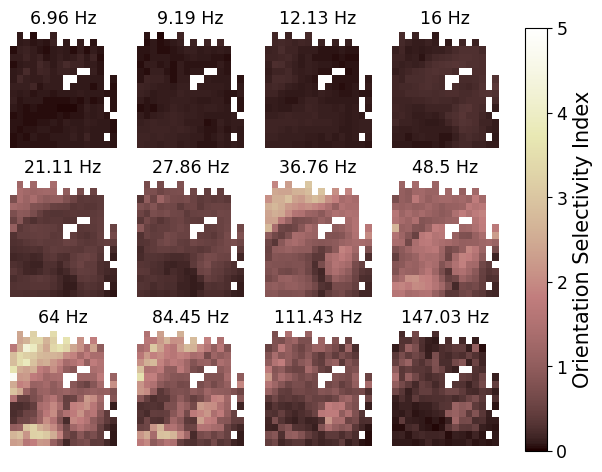

In [11]:
vmin, vmax = np.nanmin(OSIs), np.nanmax(OSIs)

# fig, axes = plt.subplots(2, 3, figsize=(6, 4))
# fig, axes = plt.subplots(3, 3, figsize=(5.5, 5.5))
fig, axes = plt.subplots(3, 4, figsize=(7, 5.5))
# freqs_toplot = [4, 8, 16, 32, 64, 128]
# freqs_toplot = [8, 13.93, 24.25, 42.22, 73.52, 128]
# freqs_toplot = [5.28, 8, 12.13, 18.38, 27.86, 42.22, 64, 97.01, 147.03]
freqs_toplot = [6.96, 9.19, 12.13, 16., 21.11, 27.86, 36.76, 48.5, 64, 84.45, 111.43, 147.03]
for freq, ax in zip(freqs_toplot, axes.ravel()):
    idx = list(freqs).index(freq)
    vals = OSIs[idx]
    vals[c_mask] = np.nan
    h = ax.imshow(vals.reshape(16, 16), extent=[0, 6.8, 0, 7.4], cmap='pink', vmin=vmin, vmax=vmax)
    ax.set_title('{:g} Hz'.format(freq), fontsize='small')
    ax.axis('off')
cbar = plt.colorbar(h, ax=axes, fraction=0.05, shrink=1, label='Orientation Selectivity Index')
fig.savefig(FIG_PATH/'tuning.index_chip.svg')

Orientation tuning of band centered at 64 Hz


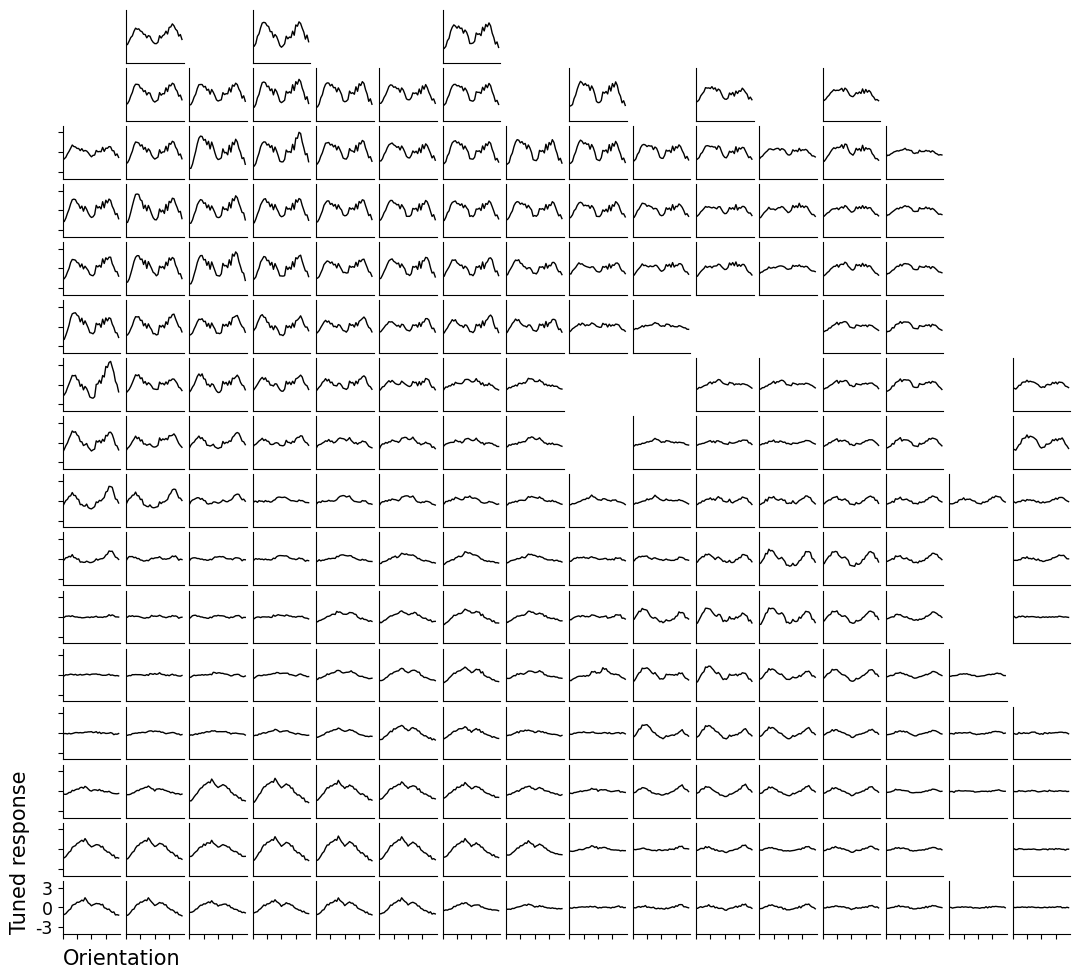

In [12]:
freq = 64
print('Orientation tuning of band centered at {:g} Hz'.format(freq))
# vals = tunings_fit[list(freqs).index(freq)]
# save_path = FIG_PATH/'tuning.curves_chip_{:g}Hz_fit.svg'.format(freq)
vals = tunings[list(freqs).index(freq)]
save_path = FIG_PATH/'tuning.curves_chip_{:g}Hz_raw.svg'.format(freq)

vlim = np.nanmax(np.abs(vals))
vlim = np.ceil(vlim/0.5)*0.5
ytick = int(np.floor(vlim*0.8))
fig, axes = plt.subplots(16, 16, figsize=(13, 12), gridspec_kw={'hspace': 0.1, 'wspace': 0.1})
for i, ax in enumerate(axes.ravel()):
    if i not in channel_idxs:
        ax.axis('off')
        continue
    ax.plot(thetas, vals[:, i], linewidth=1, color='black')
    ax.set_xlim([0, 180])
    if ax in axes[-1]:
        ax.set_xticks([0, 45, 90, 135])
    else:
        ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_ylim([-vlim, vlim])
    if ax in axes[:, 0]:
        ax.set_yticks([-ytick, 0, ytick])
    else:
        ax.set_yticks([])
    ax.set_yticklabels([])
ax = axes[-1, 0]
ax.set_xlabel('Orientation', loc='left')
ax.set_yticklabels([-ytick, 0, ytick])
ax.set_ylabel('Tuned response', loc='bottom')
# fig.savefig(save_path)

plt.show()